In [1]:
include("speciale_tools.jl")
import JLD
import PyPlot

In [22]:
function contours_to_coordinates_v2(contours,geo_lut)
    contours_coords =  deepcopy(contours)
    
    lat_grid = geo_lut["latitude"]
    lon_grid = geo_lut["longitude"]
    
    for i in 1:length(contours)
        ## contours in line and sample
        index_1 = (contours[i][:,1].-1) 
        index_2 = (contours[i][:,2].-1) 

        contours_coords[i][:,1] = ndimage.map_coordinates(lat_grid,[index_1,index_2],mode="nearest")
        contours_coords[i][:,2] = ndimage.map_coordinates(lon_grid,[index_1,index_2],mode="nearest")
    end
    
    return contours_coords
end

contours_to_coordinates_v2 (generic function with 1 method)

## Vejle

In [17]:
data_folder = "/Users/simon/Documents/DTU fag/Speciale/vejle_new/flood"

VV = [JLD.load(joinpath(data_folder,"VV_co.jld"),"data"),
    JLD.load(joinpath(data_folder,"VV_pre_median.jld"),"data")]


VH = [JLD.load(joinpath(data_folder,"VH_co.jld"),"data"), 
    JLD.load(joinpath(data_folder,"VH_pre_median.jld"),"data")];

VV_flood = JLD.load(joinpath(data_folder,"VVhand_tuned_mask.jld"),"data")[:,end:-1:1] 
VH_flood = JLD.load(joinpath(data_folder,"VHhand_tuned_mask.jld"),"data")[:,end:-1:1];

geo_lut = JLD.load(joinpath(splitdir(data_folder)[1] ,"coordinates.jld"));

In [19]:
kernel = zeros(3,3)
kernel[2,:] .= 1
kernel[:,2] .= 1
kernel = ones(2,2)
flood_combi = skimage_morph.binary_closing(VV_flood.| VH_flood ,kernel);
flood_combi  = skimage_morph.binary_opening(flood_combi ,kernel);

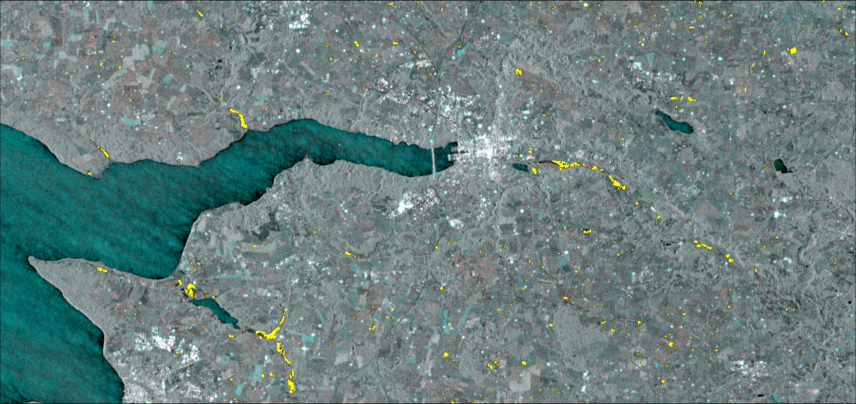

In [20]:
imgVV = pretty_img(VV)
add_mask(imgVV,flood_combi, (1,1,0))

In [23]:
water_contours = find_contours(flood_combi)
close_contours!(water_contours);
water_polygons = contours_to_coordinates_v2(water_contours,geo_lut);
water_polygons = shapely_polygon.(water_polygons);
number = collect(1:length(water_contours));
data_dict = Dict{String,Array}("id_number" => number)

Dict{String,Array} with 1 entry:
  "id_number" => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  330, 331, 332, 333, 334, 33…

In [24]:
number_of_pixels = [length(poly_slize(VV_flood,elem)) for elem in water_contours];
data_dict["Pixel_count"] = number_of_pixels;
data_dict["VV_flood"] =[sum(poly_slize(VV_flood,elem)) for elem in water_contours]./number_of_pixels
data_dict["VH_flood"] =[sum(poly_slize(VH_flood,elem)) for elem in water_contours]./number_of_pixels
data_dict["VV_VH_flood"] =[sum(poly_slize(VV_flood .& VH_flood,elem)) for elem in water_contours]./number_of_pixels;

tosmall = (data_dict["VV_VH_flood"].<0.2) .&  (data_dict["Pixel_count"] .< 10);
[data_dict[key] = elem[tosmall .!=true] for (key,elem) in data_dict];

In [25]:
data_dict["Polygon"] = water_polygons[tosmall .!=true];
gdf = geopandas_df(data_dict,"Polygon");

In [26]:
save_shape_zip(gdf,"flood_vejle_tuned",data_folder)

Process(`rm -r '/Users/simon/Documents/DTU fag/Speciale/vejle_new/flood/flood_vejle_tuned'`, ProcessExited(0))

## Ribe

In [27]:
data_folder = "/Users/simon/Documents/DTU fag/Speciale/ribe_new/flood"

VV = [JLD.load(joinpath(data_folder,"VV_co.jld"),"data"),
    JLD.load(joinpath(data_folder,"VV_pre_median.jld"),"data")]


VH = [JLD.load(joinpath(data_folder,"VH_co.jld"),"data"), 
    JLD.load(joinpath(data_folder,"VH_pre_median.jld"),"data")];

VV_flood = JLD.load(joinpath(data_folder,"VVhand_tuned_mask.jld"),"data")[end:-1:1,:] 
VH_flood = JLD.load(joinpath(data_folder,"VHhand_tuned_mask.jld"),"data")[end:-1:1,:];

geo_lut = JLD.load(joinpath(splitdir(data_folder)[1] ,"coordinates.jld"));

In [28]:
kernel = zeros(3,3)
kernel[2,:] .= 1
kernel[:,2] .= 1
kernel = ones(2,2)
flood_combi = skimage_morph.binary_closing(VV_flood.| VH_flood ,kernel);
flood_combi  = skimage_morph.binary_opening(flood_combi ,kernel);

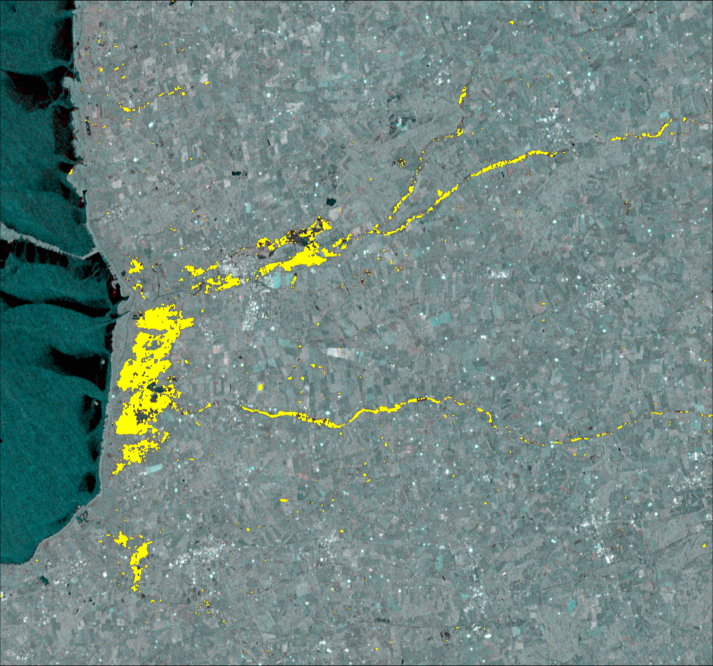

In [31]:
imgVV = pretty_img(VV,min_vv,max_vv)
add_mask(imgVV,flood_combi, (1,1,0))

In [32]:
water_contours = find_contours(flood_combi)
close_contours!(water_contours);
water_polygons = contours_to_coordinates_v2(water_contours,geo_lut);
water_polygons = shapely_polygon.(water_polygons);
number = collect(1:length(water_contours));
data_dict = Dict{String,Array}("id_number" => number)

Dict{String,Array} with 1 entry:
  "id_number" => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  576, 577, 578, 579, 580, 58…

In [33]:
number_of_pixels = [length(poly_slize(VV_flood,elem)) for elem in water_contours];
data_dict["Pixel_count"] = number_of_pixels;
data_dict["VV_flood"] =[sum(poly_slize(VV_flood,elem)) for elem in water_contours]./number_of_pixels
data_dict["VH_flood"] =[sum(poly_slize(VH_flood,elem)) for elem in water_contours]./number_of_pixels
data_dict["VV_VH_flood"] =[sum(poly_slize(VV_flood .& VH_flood,elem)) for elem in water_contours]./number_of_pixels;

tosmall = (data_dict["VV_VH_flood"].<0.2) .&  (data_dict["Pixel_count"] .< 10);
[data_dict[key] = elem[tosmall .!=true] for (key,elem) in data_dict];

In [34]:
data_dict["Polygon"] = water_polygons[tosmall .!=true];
gdf = geopandas_df(data_dict,"Polygon");

In [35]:
save_shape_zip(gdf,"flood_Ribe_tuned",data_folder)

Process(`rm -r '/Users/simon/Documents/DTU fag/Speciale/ribe_new/flood/flood_Ribe_tuned'`, ProcessExited(0))

## Houston

In [36]:
data_folder = "/Users/simon/Documents/DTU fag/Speciale/houston_new/flood"

VV = [JLD.load(joinpath(data_folder,"VV_co.jld"),"data"),
    JLD.load(joinpath(data_folder,"VV_pre_median.jld"),"data")]


VH = [JLD.load(joinpath(data_folder,"VH_co.jld"),"data"), 
    JLD.load(joinpath(data_folder,"VH_pre_median.jld"),"data")];

VV_flood = JLD.load(joinpath(data_folder,"VVhand_tuned_mask.jld"),"data")[:,end:-1:1] 
VH_flood = JLD.load(joinpath(data_folder,"VHhand_tuned_mask.jld"),"data")[:,end:-1:1];

geo_lut = JLD.load(joinpath(splitdir(data_folder)[1] ,"coordinates.jld"));

In [37]:
imgVV = pretty_img(VV,min_vv,max_vv)
kernel = zeros(3,3)
kernel[2,:] .= 1
kernel[:,2] .= 1
kernel = ones(2,2)
flood_combi = skimage_morph.binary_closing(VV_flood.| VH_flood ,kernel);
flood_combi  = skimage_morph.binary_opening(flood_combi ,kernel);

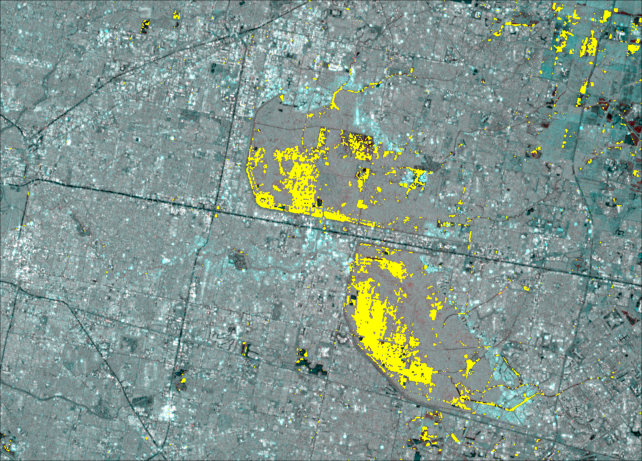

In [38]:
add_mask(imgVV,flood_combi, (1,1,0))

In [39]:
water_contours = find_contours(flood_combi)
close_contours!(water_contours);
water_polygons = contours_to_coordinates_v2(water_contours,geo_lut);
water_polygons = shapely_polygon.(water_polygons);
number = collect(1:length(water_contours));
data_dict = Dict{String,Array}("id_number" => number)

Dict{String,Array} with 1 entry:
  "id_number" => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1012, 1013, 1014, 1015, 101…

In [40]:
number_of_pixels = [length(poly_slize(VV_flood,elem)) for elem in water_contours];
data_dict["Pixel_count"] = number_of_pixels;
data_dict["VV_flood"] =[sum(poly_slize(VV_flood,elem)) for elem in water_contours]./number_of_pixels
data_dict["VH_flood"] =[sum(poly_slize(VH_flood,elem)) for elem in water_contours]./number_of_pixels
data_dict["VV_VH_flood"] =[sum(poly_slize(VV_flood .& VH_flood,elem)) for elem in water_contours]./number_of_pixels;

tosmall = (data_dict["VV_VH_flood"].<0.2) .&  (data_dict["Pixel_count"] .< 10);
[data_dict[key] = elem[tosmall .!=true] for (key,elem) in data_dict];

In [41]:
data_dict["Polygon"] = water_polygons[tosmall .!=true];
gdf = geopandas_df(data_dict,"Polygon");

In [42]:
save_shape_zip(gdf,"flood_houston_tuned",data_folder)

Process(`rm -r '/Users/simon/Documents/DTU fag/Speciale/houston_new/flood/flood_houston_tuned'`, ProcessExited(0))